In [1]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

# Part 1:  Data preprocessing


This project deals with a lot of data that can be too much for a personal computer to handle effectively. For instance, each month of yellow taxi data is about 2GB in size. Therefore, it’s imperative that you remove any unnecessary and invalid data, use appropriate data types when possible, and take samples.

For this part, you will need to use the requests, BeautifulSoup, and pandas packages to help you programmatically download and clean every Yellow Taxi CSV file needed. Cleaning the data includes: removing unnecessary columns and invalid data points, normalizing column names, and removing trips that start and/or end outside of the following latitude/longitude coordinate box: (40.560445, -74.242330) and (40.908524, -73.717047). 

While you will not need to programmatically download the Uber data, you will need to load it in from your computer, and clean the dataset as you did with the Yellow Taxi datasets.

Each month of Yellow Taxi data contains millions of trips. However, the provided Uber dataset is only a sampling of all data. Therefore, you will need to generate a sampling of Yellow Taxi data that’s roughly equal to the sample size of the Uber dataset.

Also within this part, define a function that calculates the distance between two coordinates in kilometers that only uses the `math` module from the standard library. Write at least one unit test that tests this calculation function. 

Using that function that calculates the distance in kilometers between two coordinates, add a column to each dataset that contains the distance between the pickup and dropoff location.

Finally, load in the weather datasets from your computer, and clean each dataset, including only the dates & columns needed to answer the questions in the other parts of the project.

Tips:
Downloading Yellow Taxi data can take a while per file since each file is so large. Consider saving the sample data for each month to your computer in case you need to step away, and load it back in when you return.
Relatedly, make use of your .gitignore file to avoid committing the Yellow Taxi sample dataset CSV files to your repo.
Read ahead to figure out which columns are absolutely necessary for each dataset.
Be mindful of the data types for each column, which will make it easier for yourself when storing and filtering data later on.
Use the re module to help pull out the desired links for Yellow Taxi CSV files.


In [2]:


import requests
import csv
import numpy as np
import pandas as pd
import urllib.request
import datetime 
import io
import matplotlib.pyplot as plt
import bs4
import numpy as np
import seaborn as sns
import math

import geopy.distance
from pathlib import Path



# Defining function to calculate the distance

In [3]:


def calculate_distance(from_coord, to_coord):
    def deg2rad(deg):
        return deg * (np.pi/180)
    def hav(theta):
        return np.sin(theta/2)**2

    from_coord = list(from_coord)
    to_coord = list(to_coord)
    d = []
    
    for i in range(len(from_coord)):
        x1 = from_coord[i][0]
        y1 = from_coord[i][1]
        x2 = to_coord[i][0]
        y2 = to_coord[i][1]
        R = 6371.009 # Radius of the earth in km
        dLat = deg2rad(x2-x1)
        dLon = deg2rad(y2-y1) 
        c = np.arcsin(np.sqrt(hav(dLat) + (1 - hav(deg2rad(x1 - x2)) - hav(deg2rad(x1 + x2)))*hav(dLon)))
        d.append(2 * R * c) #Distance in km
    return d

def test_calculate_distance():
    coords_1 = (52.2296756, 21.0122287)
    coords_2 = (52.406374, 16.9251681)

    print (geopy.distance.geodesic(coords_1, coords_2).km)

test_calculate_distance()
from_coord = [[52.2296756, 21.0122287]]
to_coord = [[52.406374, 16.9251681]]
calculate_distance(from_coord, to_coord)

279.35290160430094


[278.45856843965987]

# Getting the number of samples of each year and month of the uber rides.

In [4]:

#Getting the number of samples of each year and month of the uber rides.
file = "uber_rides_sample.csv"
df_uber = pd.read_csv(file)


initial_year = 2009
ending_year = 2015

initial_month = 1
ending_month = 12

counter_sample = {}

df_uber['Year'] = df_uber['key'].str.slice(0, 4)
df_uber['Month'] = df_uber['key'].str.slice(5, 7)

for year in range(initial_year,ending_year + 1):
    for month in range(initial_month, ending_month + 1):
        if month < 10:
            aux = df_uber[df_uber["Year"] == str(year)]
            aux = aux[aux["Month"] == "0"+str(month)]
            counter_sample[str(year)+"-0"+str(month)] = len(aux)
        else: 
            aux = df_uber[df_uber["Year"] == str(year)]
            aux = aux[aux["Month"] == str(month)]
            counter_sample[str(year)+"-"+str(month)] = len(aux)
            
counter_sample  
values = sum(counter_sample.values())
print("The total number of samples is: ",values)
#print(counter_sample)
df_uber

The total number of samples is:  200000


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,2015,05
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2009,07
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,2009,08
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,2009,06
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2014,08
...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,2012,10
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,2014,03
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,2009,06
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,2015,05


# Function to find the urls

In [5]:


#Function to find the urls
def find_taxi_csv_urls():
    years = [2009,2010,2011,2012,2013,2014,2015]
    TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
    content = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(content.text, 'html.parser')
    divs = soup.find_all("div")
    new_divs1 = []
    new_divs2 = []
    
    ancors = soup.find_all("a")
    ancors_yellow = []
    
    for i in ancors:
        if 'title' in i.attrs.keys() and i["title"] == "Yellow Taxi Trip Records" and int(i["href"][-11:-7]) in years:
            ancors_yellow.append(i["href"])
    
    return ancors_yellow



urls = find_taxi_csv_urls()
urls


['https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-02.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-03.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-04.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-06.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-07.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-08.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-09.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-10.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-11.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-12.csv',
 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2014-01.csv',
 'https://s3.amazonaws.co

#  Sampling the yellow taxi rides.


In [6]:
#Sampling the yellow taxi rides.


def sampling(urls):
    for url in urls:
        year = url[-11:-7]
        month = url[-6:-4]
        print(url)
        df = pd.read_csv(url)
        print("The length of the original file is: ", len(df))

        df_taxi = df.sample(n = counter_sample[url[-11:-4]], random_state = 1)
        print("The length of the sample (year, month) = ({},{}) is {}".format(year,month,len(df_taxi)))   

        df_taxi.to_csv("taxi_rides_sample"+ year +"-"+month +".csv")
        print("ok")

        
urls = find_taxi_csv_urls()
print(urls)
#df = pd.read_csv(urls)    
sampling(urls)




['https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2012-02.csv']


# Calculating distance and adding it as a column

In [7]:
#Calculating distance and adding it as a column
def limits_coord(df):
    lower_limit_x = 40.560445
    upper_limit_x = 40.908524
    lower_limit_y = -74.242330
    upper_limit_y = -73.717047
    df = df[df["Start_Lat"] > lower_limit_x]
    df = df[df["Start_Lat"] < upper_limit_x]
    df = df[df["End_Lat"] > lower_limit_x]
    df = df[df["End_Lat"] < upper_limit_x]    
    
    df = df[df["Start_Lon"] > lower_limit_y]
    df = df[df["Start_Lon"] < upper_limit_y]
    df = df[df["End_Lon"] > lower_limit_y]
    df = df[df["End_Lon"] < upper_limit_y]      
    
    return df

def dist(df):
    from_coord, to_coord = df[["Start_Lat","Start_Lon"]].values, df[["End_Lat","End_Lon"]].values
    distance = calculate_distance(from_coord, to_coord)
    df["Distance"] = distance
    return df

#df = limits_coord(df)
#df = dist(df)





# Renaming the columns

In [8]:
###Renaming the columns

def df_rename(option, ref, df):
    for i in range(len(option)):
        df[ref[i]] = df[ref[i]].fillna(df[option[i]])
        
    return df



# Read csv

In [9]:
##Read csv

def read_csv_files(st):
    
    initial_year = "2009"
    initial_month = "01"
    
    ending_year = "2015"
    ending_month = "12"
    
    for year in range(int(initial_year), int(ending_year) + 1):
        for month in range(int(initial_month), int(ending_month) + 1):
            
            if int(month) < 10:
                month_s = "0" + str(month)
            else:
                month_s = str(month)
            year_s = str(year)
            
            if year == int(initial_year) and month == int(initial_month):
                file = "taxi_rides_sample"+ year_s +"-"+ month_s +".csv"
                path = Path(file)
                if path.is_file():
                    df = pd.read_csv(file)
                    if st:
                        pass
                        #print("(year, month) = ({}, {})".format(year_s,month_s))
            else:
                #print("the else")
                file = "taxi_rides_sample"+ year_s +"-" + month_s +".csv"
                path = Path(file)
                if path.is_file():
                    aux = pd.read_csv(file)

                    df = pd.concat([df, aux])
                    if st:
                        pass
                        #print("(year, month) = ({}, {})".format(year_s,month_s))
                        
                        


    option = ["tolls_amount", "total_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime", "tip_amount",  "passenger_count", "pickup_latitude", "pickup_longitude", "dropoff_longitude", "dropoff_latitude"]
    ref = ["Tolls_Amt", "Total_Amt", "Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "Tip_Amt", "Passenger_Count", "Start_Lat", "Start_Lon", "End_Lon","End_Lat"]
    df = df_rename(option, ref, df)


    option = ["Tolls_Amt", "Total_Amt", "pickup_datetime", "dropoff_datetime", "tip_amount",  "passenger_count", "pickup_latitude", "pickup_longitude", "dropoff_longitude", "dropoff_latitude"]
    ref = ["Tolls_Amt", "Total_Amt", "Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "Tip_Amt", "Passenger_Count", "Start_Lat", "Start_Lon", "End_Lon","End_Lat"]
    df = df_rename(option, ref, df)
    df = df[ref]

    df = limits_coord(df)
    df = dist(df)
    df[df["Tolls_Amt"]>0]
    df = df[df['Trip_Pickup_DateTime'].notna()]
    df = df[df['Distance'].notna()]
    
    return df
   


# Renaming Uber data

In [10]:
#Renaming Uber data

def df_rename_uber(option, ref, df):
    for i in range(len(option)):
        #print("(option, ref): ({},{})".format(option[i],ref[i]))
        df = df.rename(columns = {option[i]: ref[i]})
    return df




# Setting limits to the coordinates of Uber data

In [11]:
def get_uber_data():
    file = "uber_rides_sample.csv"
    df_uber = pd.read_csv(file)

    option = ["fare_amount", "pickup_datetime", "passenger_count", "pickup_latitude", "pickup_longitude", "dropoff_longitude", "dropoff_latitude"]
    ref = ["Total_Amt", "Trip_Pickup_DateTime", "Passenger_Count", "Start_Lat", "Start_Lon", "End_Lon","End_Lat"]

    df_uber = df_rename_uber(option, ref, df_uber)

    df_uber = limits_coord(df_uber)
    df_uber = dist(df_uber)
    df_uber = df_uber
    df_uber.dropna()
    return df_uber


# Processing Weather Data



In [12]:
def clean_month_weather_data_hourly(csv_file):
    df = pd.read_csv(csv_file)
    lower_limit_x = 40.560445
    upper_limit_x = 40.908524
    lower_limit_y = -74.242330
    upper_limit_y = -73.717047
    df = df[df["LATITUDE"] > lower_limit_x]
    df = df[df["LATITUDE"] < upper_limit_x]
    df = df[df["LONGITUDE"] > lower_limit_y]
    df = df[df["LONGITUDE"] < upper_limit_y]    
    df = df[["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]]
    df = df.fillna(0)
    return df

    
    
def clean_month_weather_data_daily(csv_file):
    df = pd.read_csv(csv_file)
    lower_limit_x = 40.560445
    upper_limit_x = 40.908524
    lower_limit_y = -74.242330
    upper_limit_y = -73.717047
    df = df[df["LATITUDE"] > lower_limit_x]
    df = df[df["LATITUDE"] < upper_limit_x]
    df = df[df["LONGITUDE"] > lower_limit_y]
    df = df[df["LONGITUDE"] < upper_limit_y]    
    df = df[["DATE", "DailyAverageWindSpeed", "DailyPrecipitation"]]
    df = df.fillna(0)
    return df
    

def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = []
    for i in range(2009,2016):
        weather_csv_files.append(str(i)+"_weather.csv")
        
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data




In [13]:
taxi_data = read_csv_files(True)
uber_data = get_uber_data()
hourly_weather, daily_weather = load_and_clean_weather_data()
print(uber_data.head)
print(taxi_data.info(verbose=True))



C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/2311915740.py:44: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)
C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/2311915740.py:45: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/2311915740.py:44: DtypeWarning: Columns (8,9,10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)
C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/2311915740.py:45: DtypeWarning: Columns (8,9,10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/2311915740.p

<bound method NDFrame.head of         Unnamed: 0                            key  Total_Amt  \
0         24238194    2015-05-07 19:52:06.0000003        7.5   
1         27835199    2009-07-17 20:04:56.0000002        7.7   
2         44984355   2009-08-24 21:45:00.00000061       12.9   
3         25894730    2009-06-26 08:22:21.0000001        5.3   
4         17610152  2014-08-28 17:47:00.000000188       16.0   
...            ...                            ...        ...   
199995    42598914   2012-10-28 10:49:00.00000053        3.0   
199996    16382965    2014-03-14 01:09:00.0000008        7.5   
199997    27804658   2009-06-29 00:42:00.00000078       30.9   
199998    20259894    2015-05-20 14:56:25.0000004       14.5   
199999    11951496   2010-05-15 04:08:00.00000076       14.1   

           Trip_Pickup_DateTime  Start_Lon  Start_Lat    End_Lon    End_Lat  \
0       2015-05-07 19:52:06 UTC -73.999817  40.738354 -73.999512  40.723217   
1       2009-07-17 20:04:56 UTC -73.994355 

C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/2311915740.py:45: DtypeWarning: Columns (10,41,78) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)


# Part 2: Storing Data
Using SQLAlchemy, create a SQLite database with which you’ll load in your preprocessed datasets.

Create and populate four tables: one for your sampled datasets of Yellow Taxi trips, one for Uber trips, one for hourly weather information, and one for daily weather information. Use appropriate data types for each column. 

Create a schema.sql file that defines each table’s schema. You can use SQLAlchemy within the notebook to help generate this file, (added 2022-04-21) or another programmatic approach, or create this schema file by hand.

Tips (added 2022-04-21):
The first 48 lines of this gist is a good example of what makes up a schema file.
I should be able to run this schema file to create the tables in a database via the SQLite CLI tool. That is, I should be able to run the following command in a Jupyter notebook cell to create a database with the four required tables (it is not expected that you do this yourself for the project, but this is a good sanity check for it to succeed without error):

	!sqlite3 project.db < schema.sql


In [14]:
import sqlite3

connection = sqlite3.connect("project.db")

# Tables

In [15]:
# using SQL

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS yellow_taxi_trips (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   distance_traveled REAL
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_taxi_trips (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   distance_traveled REAL
);
"""

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS weather_data_hourly (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   wind_speed REAL,
   precipitation REAL
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS weather_data_daily (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   wind_speed REAL,
   precipitation REAL
   
);
"""

In [16]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    

# Creating the tables

In [17]:
# create the tables with the schema files
with connection:
    connection.execute(TAXI_TRIPS_SCHEMA)
with connection:
    connection.execute(UBER_TRIPS_SCHEMA)
with connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
with connection:
    connection.execute(DAILY_WEATHER_SCHEMA)

# Converting df to tables

In [18]:
def dataframes_to_table(dic):
    
    with connection:

        for index, row in dic["taxi_trips"].iterrows():
            dist = row['Distance']
            date = row['Trip_Pickup_DateTime']
            
            connection.execute("""
                INSERT INTO yellow_taxi_trips (date_and_time,distance_traveled) 
                VALUES("{dt}",{di})
                """.format(dt=date, di=dist))
            
        for index, row in dic["uber_trips"].iterrows():
            dist = row['Distance']
            date = row['Trip_Pickup_DateTime'][:-4]
            connection.execute("""
                INSERT INTO uber_taxi_trips (date_and_time,distance_traveled) 
                VALUES("{date}",{dist})
                """.format(date=date, dist=dist))


        for index, row in dic["hourly_weather"].iterrows():
            date = row['DATE']
            date = date.replace("T"," ")
            
            preci = str(row['HourlyPrecipitation'])
            if preci == "T":
                preci = "0"
            if preci[-1] == "s":
                preci = preci[:len(preci)-1]
            windspeed = str(row['HourlyWindSpeed'])
            connection.execute("""
                INSERT INTO weather_data_hourly (date_and_time,wind_speed,precipitation)
                VALUES("{date}",{precipitation},{windspeed})
                """.format(date=date,precipitation=preci,windspeed=preci))

        
        for index, row in dic["daily_weather"].iterrows():
            date = row['DATE']
            date = date.replace("T"," ")
                               
            preci = str(row['DailyPrecipitation'])
            if preci == "T":
                preci = "0"
            if preci[-1] == "s":
                preci = preci[:len(preci)-1]
            windspeed = str(row['DailyAverageWindSpeed'])
            connection.execute("""
                INSERT INTO weather_data_daily (date_and_time,wind_speed,precipitation)
                VALUES("{date}",{precipitation},{windspeed})
                """.format(date=date,precipitation=preci,windspeed=preci))

            

        

In [19]:
table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather,
    "daily_weather": daily_weather,
}

dataframes_to_table(table_name_to_dataframe)

def print_query(q):
    for r in q:
        print(r)


        
with connection:
    print("Yello Taxi")
    print_query(connection.execute('SELECT * FROM yellow_taxi_trips LIMIT 10'))
    
with connection:
    print("Uber Taxi")
    print_query(connection.execute('SELECT * FROM uber_taxi_trips LIMIT 10'))

with connection:
    print("Hourly Wind")
    print_query(connection.execute('SELECT * FROM weather_data_hourly LIMIT 10'))

with connection:
    print("Daily Wind")
    print_query(connection.execute('SELECT * FROM weather_data_daily LIMIT 10'))
  
    

Yello Taxi
(1, '2009-01-18 03:05:00', 1.2982043177692106)
(2, '2009-01-11 16:16:20', 1.9557909628855965)
(3, '2009-01-27 22:31:35', 0.9636390245878174)
(4, '2009-01-10 14:20:57', 3.6404767440573735)
(5, '2009-01-18 00:48:00', 1.3905634312691584)
(6, '2009-01-27 20:26:56', 5.265714155142061)
(7, '2009-01-06 12:26:00', 3.776697327072962)
(8, '2009-01-15 06:50:00', 7.3741598289020684)
(9, '2009-01-22 08:31:00', 2.6992881600044236)
(10, '2009-01-04 02:35:00', 1.8062657047689292)
Uber Taxi
(1, '2015-05-07 19:52:06', 1.6833251303506676)
(2, '2009-07-17 20:04:56', 2.457593355496059)
(3, '2009-08-24 21:45:00', 5.036384304886479)
(4, '2009-06-26 08:22:21', 1.6616858058144466)
(5, '2014-08-28 17:47:00', 4.475456285277511)
(6, '2011-02-12 02:27:09', 0.0)
(7, '2014-10-12 07:04:00', 11.731031455369624)
(8, '2012-02-17 09:32:00', 2.3327143046469434)
(9, '2012-03-29 19:06:00', 4.889423795144333)
(10, '2015-05-22 17:32:27', 2.250860801536827)
Hourly Wind
(1, '2009-01-01 00:51:00', 0.0, 0.0)
(2, '2009-

# Part 3: Understanding Data
For this part, define a SQL query for each of the following questions - one query per question. Save each query as a .sql file, naming it something illustrative of what the query is for, e.g. top_10_hottest_days.sql.

For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.
For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.
What is the 95% percentile of distance traveled for all hired trips during July 2013?
What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?
During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

For each query, be sure to execute it in the notebook so we can see your answers to the question.

Tips:
You may wish to use SQLAlchemy within the notebook to help craft these queries and query files. You can also use pandas to help check the validity of your queries.
You may want to familiarize yourself with COALESCE, WITH, and WITH RECURSIVE expressions for help in answering some of the questions.
See appendix of lecture notes from module #10 for more tips/hints


In [20]:
def write_query_to_file(query, outfile):
    f = open(outfile,"w")
    for i in query:
        f.write(query+"\n")
    f.close()

# Tables

In [21]:
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS yellow_taxi_trips (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   distance_traveled REAL
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_taxi_trips (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   distance_traveled REAL
);
"""

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS weather_data_hourly (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   wind_speed REAL,
   precipitation REAL
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS weather_data_daily (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date_and_time DATETIME,
   wind_speed REAL,
   precipitation REAL
   
);
"""

# Queries

In [22]:
QUERY_1 = """
SELECT strftime('%H',date_and_time),COUNT(strftime('%H',date_and_time))
FROM yellow_taxi_trips
WHERE date_and_time >= "2009-01-01" AND date_and_time <= "2015-06-01"
GROUP BY strftime('%H',date_and_time)
ORDER BY COUNT(strftime('%H',date_and_time)) DESC
"""

QUERY_2 = """
SELECT substr('SunMonTueWedThuFriSat', 1 + 3*strftime('%w', date_and_time), 3) as dow ,count(strftime('%w',date_and_time))
FROM uber_taxi_trips
WHERE date_and_time >= "2009-01-01" AND date_and_time <= "2015-06-01"
GROUP BY strftime('%w',date_and_time)
ORDER BY COUNT(strftime('%w',date_and_time)) DESC
"""

QUERY_3 = """
SELECT distance_traveled
FROM
(SELECT distance_traveled
FROM yellow_taxi_trips
UNION ALL
SELECT distance_traveled
FROM uber_taxi_trips) AS T
ORDER BY distance_traveled ASC
LIMIT 1
OFFSET (SELECT COUNT(*)
        FROM (SELECT distance_traveled
        FROM yellow_taxi_trips
        UNION ALL
        SELECT distance_traveled
        FROM uber_taxi_trips)) * 19 / 20 - 1;
"""

QUERY_4 = """
SELECT DATE(date_and_time), count(strftime('%Y',date_and_time)), AVG(distance_traveled)
FROM 
(SELECT * from yellow_taxi_trips
UNION ALL
SELECT * from uber_taxi_trips)
WHERE strftime('%Y',date_and_time) = "2009"
GROUP BY DATE(date_and_time)
ORDER BY count(strftime('%Y',date_and_time)) DESC
LIMIT 10
"""

QUERY_5 = """
SELECT count(*)
FROM 
(SELECT *
FROM yellow_taxi_trips
UNION ALL
SELECT *
FROM uber_taxi_trips)
WHERE DATE(date_and_time) IN
        (SELECT DATE(date_and_time)
        FROM weather_data_daily
        WHERE strftime('%Y',date_and_time) = "2014"
        ORDER BY wind_speed DESC
        LIMIT 10)
"""

QUERY_6 = """
SELECT W.date, W.HR, count(*), AVG(wind_speed), AVG(precipitation)
FROM
    (SELECT DATE(date_and_time) as date, strftime('%H',date_and_time) as HR, precipitation, wind_speed
        FROM weather_data_hourly
    WHERE DATE(date) >= "2012-10-23" AND DATE(date_and_time) <= "2012-10-30") AS W
    INNER JOIN
    (SELECT DATE(date_and_time) as date, strftime('%H',date_and_time) AS HR, distance_traveled
    FROM 
        (SELECT *
            FROM yellow_taxi_trips
        WHERE DATE(date_and_time) >= "2012-10-23" AND DATE(date_and_time) <= "2012-10-30"
        UNION ALL
        SELECT *
            FROM uber_taxi_trips
        WHERE DATE(date_and_time) >= "2012-10-23" AND DATE(date_and_time) <= "2012-10-30")) AS T
    ON T.date = W.date AND T.HR = W.HR
GROUP BY W.date, W.HR
"""

In [23]:
with connection:
    q1 = connection.execute(QUERY_1) # busy hour is 6PM 18 with 310 orders

with connection:
    q2 = connection.execute(QUERY_2) # thursday is the busiest day for uber with 310 orders

with connection:
    q3 = connection.execute(QUERY_3) # thursday is the busiest day for uber with 310 orders

with connection:
    q4 = connection.execute(QUERY_4) # thursday is the busiest day for uber with 310 orders
    
with connection:
    q5 = connection.execute(QUERY_5) # thursday is the busiest day for uber with 310 orders
    
with connection:
    q6 = connection.execute(QUERY_6) # thursday is the busiest day for uber with 310 orders

QQ = [q1,q2,q3,q4,q5,q6]



count = 1
for i in QQ:
    print("Q ",count)
    names = list(map(lambda x: x[0], i.description))
    print(names)
    for j in i:
        print(j)
    count+=1

Q  1
["strftime('%H',date_and_time)", "COUNT(strftime('%H',date_and_time))"]
('19', 20646)
('18', 20070)
('20', 19042)
('21', 18968)
('22', 18098)
('14', 16808)
('17', 16428)
('23', 16116)
('13', 16072)
('12', 15798)
('15', 15748)
('11', 15384)
('09', 15140)
('08', 14852)
('10', 14784)
('16', 13584)
('00', 13070)
('07', 11698)
('01', 9824)
('02', 7036)
('06', 6710)
('03', 5190)
('04', 3682)
('05', 3252)
Q  2
['dow', "count(strftime('%w',date_and_time))"]
('Fri', 59696)
('Sat', 58580)
('Thu', 58072)
('Wed', 56112)
('Tue', 54382)
('Sun', 51142)
('Mon', 48732)
Q  3
['distance_traveled']
(9.922931592162175,)
Q  4
['DATE(date_and_time)', "count(strftime('%Y',date_and_time))", 'AVG(distance_traveled)']
('2009-12-11', 506, 2.916359267392199)
('2009-06-05', 450, 2.7500421392151635)
('2009-05-16', 442, 2.9252035194040977)
('2009-12-05', 438, 3.174492025814194)
('2009-08-14', 436, 3.207687556053114)
('2009-03-12', 436, 2.9836993999889803)
('2009-05-21', 432, 3.385604929574478)
('2009-10-23', 428

# Part 4: Visualizing the Data¶
A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you.

 Create an appropriate visualization for the first query/question in part 3
 Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
 Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
 Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
 Create a scatter plot that compares tip amount versus distance.
 Create another scatter plot that compares tip amount versus precipitation amount.
 Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.
Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted.

# Functions to visualize the data

In [24]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()
    
# use a more descriptive name for your function
def popular_hours(df):
    
    df = df.sort_values(df.columns[0], ascending = True)
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    plt.bar(x, y);
    plt.title('yellow taxi popular hours')
    plt.xlabel('hours')
    plt.ylabel('frequency')
    plt.show()
    
def average_distance(df):

    #some example data
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    #some confidence interval
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    plt.title('Average Distance')
    plt.xlabel('Months')
    plt.ylabel('Average Distance')
    plt.plot(x,y)
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.show()
    
    
def heatmap(df):
    y = df.iloc[:,0].values.tolist()
    x = df.iloc[:,1].values.tolist()
    y = [int((i - NEW_YORK_BOX_COORDS[0][0])*100) for i in y]
    x = [int((i - NEW_YORK_BOX_COORDS[0][1])*100) for i in x]

    heat_map = [ [0] * 60 for _ in range(60)]
    
    for i in range(len(x)):
        heat_map[x[i]][y[i]] += 1
        
    
    sns.heatmap(heat_map, linewidth=0.0001)
    plt.show()

def tip_and_distance(df):
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    plt.scatter(x, y, marker='o');
    plt.xlabel('distance')
    plt.ylabel('tip')
    plt.show()
    
def tip_and_precipitation(dataframe):
    df = dataframe
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    plt.scatter(x, y, marker='o');
    plt.xlabel('precipitation')
    plt.ylabel('tip')
    plt.show()

# Constructing df

In [25]:
Visulization2 = """
SELECT mo, AVG(distance_traveled)
FROM
(
    SELECT substr('JanFebMarAprMayJunJulAugSepOctNovDec', 1 + 3*strftime('%m', date_and_time), -3) as mo, distance_traveled
    FROM yellow_taxi_trips
UNION ALL
    SELECT substr('JanFebMarAprMayJunJulAugSepOctNovDec', 1 + 3*strftime('%m', date_and_time), -3)as mo, distance_traveled
    FROM uber_taxi_trips
)
GROUP BY mo
"""

dataframe1 = taxi_data[["Start_Lat","Start_Lon"]]
dataframe2 = uber_data[["Start_Lat","Start_Lon"]]


dataframe3 = taxi_data[["Distance","Tip_Amt"]]
dataframe3 = dataframe3[dataframe3.notna()]
dataframe3 = dataframe3[dataframe3["Distance"]>0]


dataframe_6_A = taxi_data[["Tip_Amt","Trip_Pickup_DateTime"]]
dataframe_6_B = hourly_weather[["DATE","HourlyPrecipitation"]]
taxi_day = []
taxi_time = []
for index, row in dataframe_6_A.iterrows():
    day1,time1 = row['Trip_Pickup_DateTime'].split()
    taxi_day.append(day1)
    taxi_time.append(time1.split(":")[0])
weather_day = []
weather_time = []
for index, row in dataframe_6_B.iterrows():
    day2,time2 = row['DATE'].split("T")
    weather_day.append(day2)
    weather_time.append(time2.split(":")[0])
    

dataframe_6_A['time'] = taxi_time
dataframe_6_A['day'] = taxi_day
dataframe_6_B['time'] = weather_time
dataframe_6_B['day'] = weather_day

dataframe_6_A = dataframe_6_A[["Tip_Amt","time","day"]]
dataframe_6_B = dataframe_6_B[["HourlyPrecipitation","time","day"]]

merged = pd.merge(dataframe_6_A,dataframe_6_B, on=['time','day'])
print(merged.head)
prec = []
for index, row in merged.iterrows():
    if(row['HourlyPrecipitation'] == "T"):
        prec.append(0)
    elif(str(row['HourlyPrecipitation'])[-1] == "s"):
        prec.append(float(row['HourlyPrecipitation'][:-1]))
    else:
        prec.append(float(row['HourlyPrecipitation']))
        

merged['HourlyPrecipitation'] = prec
    



C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/1823800208.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_6_A['time'] = taxi_time
C:\Users\rirod\AppData\Local\Temp/ipykernel_35716/1823800208.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_6_A['day'] = taxi_day


<bound method NDFrame.head of         Tip_Amt time         day HourlyPrecipitation
0           1.0   03  2009-01-18                0.35
1           0.0   03  2009-01-18                0.35
2           2.0   03  2009-01-18                0.35
3           0.0   03  2009-01-18                0.35
4           0.0   16  2009-01-11                   0
...         ...  ...         ...                 ...
210119      2.0   05  2015-06-21                0.01
210120      0.0   06  2015-06-02                   0
210121      0.0   06  2015-06-02                   0
210122      0.0   06  2015-06-02                0.00
210123      2.5   01  2015-06-22                0.00

[210124 rows x 4 columns]>


# Plots

        HourlyPrecipitation  Tip_Amt
0                      0.35      1.0
1                      0.35      0.0
2                      0.35      2.0
3                      0.35      0.0
4                      0.00      0.0
...                     ...      ...
210119                 0.01      2.0
210120                 0.00      0.0
210121                 0.00      0.0
210122                 0.00      0.0
210123                 0.00      2.5

[210124 rows x 2 columns]


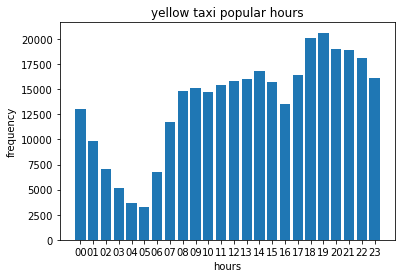

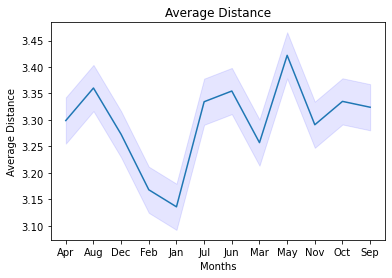

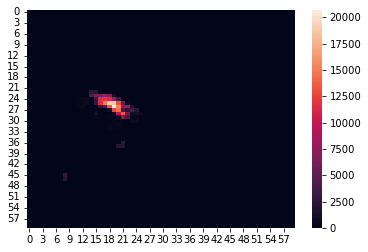

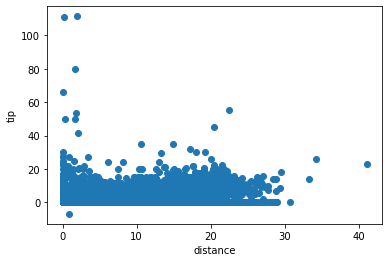

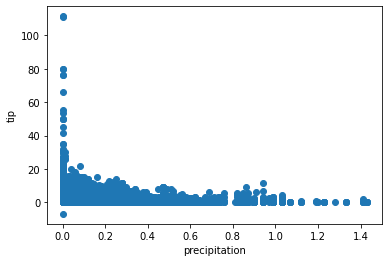

In [26]:

plot1 = pd.read_sql_query (QUERY_1, connection)
plot2 = pd.read_sql_query (Visulization2, connection)
plot4 = pd.concat([dataframe1,dataframe2])
plot4 = plot4[plot4.notna()]
plot5 = dataframe3
plot6 = merged[["HourlyPrecipitation","Tip_Amt"]]
plot6 = plot6.dropna()
print(plot6)


popular_hours(plot1)
average_distance(plot2)
heatmap(plot4)
tip_and_distance(plot5)
tip_and_precipitation(plot6)